In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import json
import seaborn as sns

In [2]:
#load previous result
folder_name = "results/job_match_0303_1550"

with open(folder_name + '/test_dict.json') as f:
    test_dict = json.load(f)

#get related occupation, filtered by primary-short (most relevant)
related = pd.read_excel('datasets/related_occupations.xlsx').astype(str)
related.columns = related.columns.str.lower().str.replace(" ","_").str.replace("o*net-soc_", "")
related = related[related["relatedness_tier"] == "Primary-Short"]


def get_result(code):
    with open(folder_name + '/' + code + '.json') as f:
        career = pd.read_json(f)

    return career

#match suggested career to the related career
def match(code, career):
    #check if direct match
    career = career[career["fit"] == "Best"]
    if len(career[career["code"] == code]) == 1: #direct match
        return 1
    else: #check related match
        related_oc = related[related["code"] == code].drop(labels=["code", "title", "relatedness_tier", "index"], axis=1)
        related_oc.columns = related_oc.columns.str.replace("related_", "")
        merged_df = related_oc.merge(right=career, on="code")
        related_match = len(merged_df) / 5
        return related_match

In [75]:
#load the test samples to df
test = pd.read_json('results/job_match_0503_1058/test_sample.json')
test

,code,title,description,ind
0,33-1012.00,First-Line Supervisors of Police and Detectives,Directly supervise and coordinate activities o...,33
1,29-2011.02,Cytotechnologists,"Stain, mount, and study cells to detect eviden...",29
2,51-3021.00,Butchers and Meat Cutters,"Cut, trim, or prepare consumer-sized portions ...",51
3,47-4021.00,Elevator and Escalator Installers and Repairers,"Assemble, install, repair, or maintain electri...",47
4,11-9161.00,Emergency Management Directors,Plan and direct disaster response or crisis ma...,11


In [76]:
#get jobzone df
jz = pd.read_excel('datasets/job_zone.xlsx')
jz.columns = jz.columns.str.lower().str.replace(" ","_")
jz = jz.drop(labels=['date', 'domain_source'], axis=1)   
jz = jz.rename(columns={'o*net-soc_code':'code', 'job_zone':'zone'})

#merge with test, only keep the zone column, drop the rest
test = test.merge(right=jz, on='code')
test = test.drop(labels=['title_y'], axis=1)
test

#use apply to calculate the match score
test['match'] = test['code'].apply(lambda x: match(x, get_result(x)))
test

,code,title_x,description,ind,zone,match
0,33-1012.00,First-Line Supervisors of Police and Detectives,Directly supervise and coordinate activities o...,33,2,0.2
1,29-2011.02,Cytotechnologists,"Stain, mount, and study cells to detect eviden...",29,5,1.0
2,51-3021.00,Butchers and Meat Cutters,"Cut, trim, or prepare consumer-sized portions ...",51,2,0.0
3,47-4021.00,Elevator and Escalator Installers and Repairers,"Assemble, install, repair, or maintain electri...",47,3,1.0
4,11-9161.00,Emergency Management Directors,Plan and direct disaster response or crisis ma...,11,4,0.0


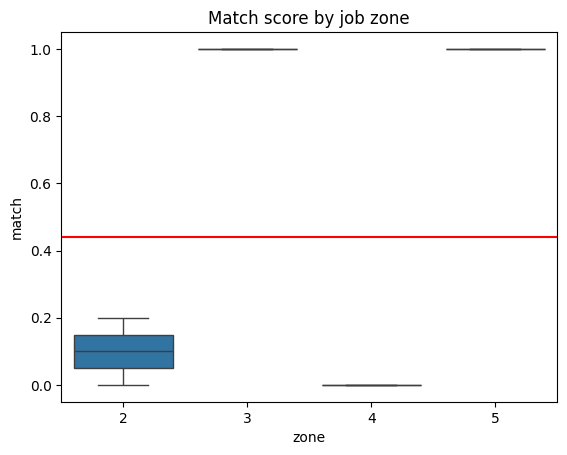

In [79]:
#plot the match score by job zone
sns.boxplot(x='zone', y='match', data=test)
#add a constant line for the average match score
plt.axhline(y=score / len(test_dict), color='r', linestyle='-')
#add title
plt.title('Match score by job zone')
plt.show()

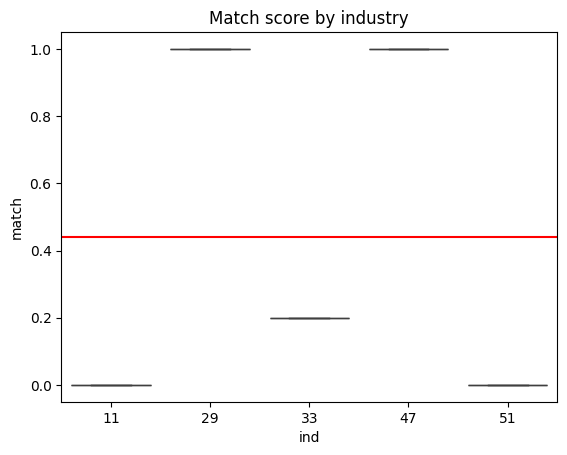

In [81]:
#plot the match score by ind
sns.boxplot(x='ind', y='match', data=test)
plt.axhline(y=score / len(test_dict), color='r', linestyle='-')
plt.title('Match score by industry')
plt.show()